# Importing required packages :

In [64]:
import os
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import shutil
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, InceptionV3, Xception, MobileNetV2
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.utils import dataset_util, label_map_util
import io


In [2]:
import tensorflow as tf
print(tf.__version__)
#tf.debugging.set_log_device_placement(True)

2.10.0


In [3]:
# Perform a simple computation
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
c = a + b

print(c)

tf.Tensor(
[[ 2.  4.  6.]
 [ 8. 10. 12.]], shape=(2, 3), dtype=float32)


# Data Exploration & Cleaning :

In [4]:
# Define paths to dataset folders
train_folder = "./Fish.v1-416x416.tensorflow/train"
valid_folder = "./Fish.v1-416x416.tensorflow/valid"
test_folder = "./Fish.v1-416x416.tensorflow/test"

In [5]:
# Define a mapping from duplicate to preferred class names
class_mapping = {
    'Scombridae -Tunas-': 'tuna',
    'Scaridae -Parrotfishes-': 'parrot',
    'Carangidae -Jacks-': 'jack',
    'Serranidae -Groupers-': 'grouper',
    'Lutjanidae -Snappers-': 'snapper',
    'Acanthuridae -Surgeonfishes-': 'surgeon',
    'Pomacentridae -Damselfishes-': 'damsel',
    'Labridae -Wrasse-': 'wrasse',
    'Pomacanthidae -Angelfishes-': 'angel',
    'Balistidae -Triggerfishes-': 'trigger',
    'Shark -Selachimorpha-': 'shark',
    'Ephippidae -Spadefishes-': 'spade',
    'Zanclidae -Moorish Idol-': 'moorish',
    'Zanclidae (Moorish Idol)': 'moorish',
    # Add other mappings as needed
}

In [6]:
# Function to read annotation files
def read_annotations(folder):
    annotation_file = os.path.join(folder, "_annotations.csv")
    return pd.read_csv(annotation_file)

def crop_images(folder, annotations):
    for index, row in annotations.iterrows():
        filename_col = annotations.columns[0]  # Assuming the first column is the filename
        filename = row[filename_col]
        image_path = os.path.join(folder, filename)
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Unable to read image '{filename}'. Skipping...")
                continue
        except Exception as e:
            print(f"Error: Unable to read image '{filename}': {str(e)}. Skipping...")
            continue

        # Map class names using the class_mapping dictionary
        original_class_name = row['class']
        class_name = class_mapping.get(original_class_name, original_class_name)  # Use mapped name if exists, else original

        class_folder = os.path.join(folder, class_name)
        if not os.path.exists(class_folder):
            os.makedirs(class_folder)

        xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']
        if xmin == xmax or ymin == ymax:  # Check if width or height is zero
            print(f"Error: Bounding box has zero width or height in image '{filename}'. Skipping...")
            continue

        cropped_img = image[ymin:ymax, xmin:xmax]
        if cropped_img.shape[0] == 0 or cropped_img.shape[1] == 0:
            print(f"Error: Cropped image '{filename}' is empty. Skipping...")
            continue

        # Save the cropped image in the appropriate class folder
        cv2.imwrite(os.path.join(class_folder, filename), cropped_img)

In [7]:
# Process datasets
for folder in [train_folder, valid_folder, test_folder]:
    annotations = read_annotations(folder)
    crop_images(folder, annotations)

Error: Bounding box has zero width or height in image 'FishDataset554_png.rf.b2XgzOC8YWtCgAaV6mbC.jpg'. Skipping...
Error: Bounding box has zero width or height in image 'FishDataset554_png.rf.27536e4740fb6e7e0324302187967adb.jpg'. Skipping...


In [8]:
df = pd.read_csv('Fish.v1-416x416.tensorflow/train/_annotations.csv')
df['class'].unique()

array(['tuna', 'surgeon', 'shark', 'jack', 'grouper', 'parrot', 'snapper',
       'damsel', 'trigger', 'Zanclidae (Moorish Idol)',
       'Scaridae -Parrotfishes-', 'Carangidae -Jacks-',
       'Scombridae -Tunas-', 'Shark -Selachimorpha-',
       'Serranidae -Groupers-', 'Lutjanidae -Snappers-',
       'Acanthuridae -Surgeonfishes-', 'Pomacentridae -Damselfishes-',
       'Labridae -Wrasse-', 'angel', 'wrasse', 'Zanclidae -Moorish Idol-',
       'Ephippidae -Spadefishes-', 'Pomacanthidae -Angelfishes-',
       'Balistidae -Triggerfishes-', 'spade'], dtype=object)

In [9]:
# Initialize a dictionary to hold the count of images per class
class_counts = {}

# Loop through each class directory in the 'train' directory
for class_name in os.listdir(train_folder):
    class_dir = os.path.join(train_folder, class_name)
    # Check if it's a directory to avoid reading non-directory files
    if os.path.isdir(class_dir):
        # Count the number of image files in the class directory
        class_counts[class_name] = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])

# Print the count of images per class
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")


angel: 2
damsel: 10
grouper: 137
jack: 159
moorish: 2
parrot: 114
shark: 138
snapper: 141
spade: 2
surgeon: 126
trigger: 2
tuna: 141
wrasse: 2


In [10]:
# Classes to be removed
classes_to_remove = ['angel', 'damsel', 'grouper', 'moorish', 'spade', 'trigger', 'wrasse']

# Directories for train, test, and validation datasets
directories = [train_folder, valid_folder, test_folder]

for directory in directories:
    for class_name in classes_to_remove:
        class_path = os.path.join(directory, class_name)
        if os.path.exists(class_path):
            shutil.rmtree(class_path)  # This deletes the directory and all its contents
            print(f"Removed {class_path}")


Removed ./Fish.v1-416x416.tensorflow/train\angel
Removed ./Fish.v1-416x416.tensorflow/train\damsel
Removed ./Fish.v1-416x416.tensorflow/train\grouper
Removed ./Fish.v1-416x416.tensorflow/train\moorish
Removed ./Fish.v1-416x416.tensorflow/train\spade
Removed ./Fish.v1-416x416.tensorflow/train\trigger
Removed ./Fish.v1-416x416.tensorflow/train\wrasse
Removed ./Fish.v1-416x416.tensorflow/valid\grouper
Removed ./Fish.v1-416x416.tensorflow/valid\moorish
Removed ./Fish.v1-416x416.tensorflow/valid\wrasse
Removed ./Fish.v1-416x416.tensorflow/test\grouper


In [11]:
from PIL import Image

def explore_image_sizes(folder):
    sizes = {}
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(root, file)
                with Image.open(image_path) as img:
                    size = img.size  # Get image size as (width, height)
                    if size in sizes:
                        sizes[size] += 1
                    else:
                        sizes[size] = 1
    return sizes

# Explore sizes in the train, validation, and test folders
train_sizes = explore_image_sizes(train_folder)
valid_sizes = explore_image_sizes(valid_folder)
test_sizes = explore_image_sizes(test_folder)

# Example to print out the sizes and their counts
print("Train sizes:", train_sizes)
print("Validation sizes:", valid_sizes)
print("Test sizes:", test_sizes)

Train sizes: {(416, 416): 944, (82, 47): 1, (126, 151): 2, (394, 391): 2, (99, 97): 2, (312, 196): 2, (97, 95): 2, (269, 274): 2, (197, 141): 2, (166, 104): 2, (384, 248): 2, (321, 266): 2, (248, 280): 2, (102, 78): 2, (249, 219): 2, (344, 302): 2, (227, 178): 2, (198, 147): 2, (179, 166): 2, (395, 373): 2, (277, 283): 2, (389, 272): 2, (94, 112): 2, (301, 204): 2, (306, 257): 2, (140, 242): 2, (283, 210): 2, (284, 220): 2, (147, 145): 2, (51, 44): 2, (346, 231): 2, (102, 83): 2, (260, 284): 2, (325, 341): 2, (237, 157): 2, (180, 254): 2, (216, 280): 2, (326, 232): 2, (313, 201): 2, (350, 259): 2, (173, 202): 2, (155, 131): 2, (314, 197): 2, (78, 76): 2, (362, 212): 2, (281, 209): 2, (181, 128): 2, (82, 95): 2, (322, 248): 2, (338, 217): 2, (353, 182): 2, (63, 71): 2, (137, 206): 2, (238, 156): 2, (388, 277): 2, (79, 70): 2, (201, 347): 2, (356, 336): 2, (103, 83): 2, (132, 98): 2, (125, 82): 2, (394, 292): 2, (175, 100): 2, (290, 386): 2, (169, 106): 4, (127, 79): 2, (224, 133): 2, (2

# Data Preprocessing :

In [12]:
# Initialize the ImageDataGenerator for rescaling the images
rescale_datagen = ImageDataGenerator(rescale=1./255)

# Prepare the datasets without augmentation, only rescaling
train_generator = rescale_datagen.flow_from_directory(
    train_folder,  # Use the variable pointing to the train directory
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical' # Because we're doing classification
)

valid_generator = rescale_datagen.flow_from_directory(
    valid_folder,  # Use the variable pointing to the validation directory
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical' # For validation, we're also doing classification
)

test_generator = rescale_datagen.flow_from_directory(
    test_folder,  # Use the variable pointing to the test directory
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='categorical', # For testing, ensure labels are available for evaluation
    shuffle=False # No need to shuffle the test data
)

Found 819 images belonging to 6 classes.
Found 230 images belonging to 6 classes.
Found 118 images belonging to 6 classes.


# Model Creation & Training :

In [13]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [14]:
input_shape = (150, 150, 3) 
num_classes = 6

In [15]:
model = create_model(input_shape, num_classes)

In [16]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=valid_generator,
    callbacks=[early_stopping]
)

Epoch 1/50
26/26 [==============================] - 6s 70ms/step - loss: 1.7563 - accuracy: 0.2930 - val_loss: 1.5664 - val_accuracy: 0.3435
Epoch 2/50
26/26 [==============================] - 1s 46ms/step - loss: 1.5181 - accuracy: 0.3516 - val_loss: 1.4840 - val_accuracy: 0.3522
Epoch 3/50
26/26 [==============================] - 1s 49ms/step - loss: 1.4404 - accuracy: 0.4249 - val_loss: 1.4304 - val_accuracy: 0.3696
Epoch 4/50
26/26 [==============================] - 1s 45ms/step - loss: 1.3271 - accuracy: 0.4762 - val_loss: 1.4555 - val_accuracy: 0.3652
Epoch 5/50
26/26 [==============================] - 1s 46ms/step - loss: 1.1971 - accuracy: 0.5226 - val_loss: 1.4235 - val_accuracy: 0.4696
Epoch 6/50
26/26 [==============================] - 1s 42ms/step - loss: 1.0245 - accuracy: 0.6142 - val_loss: 1.4659 - val_accuracy: 0.4261
Epoch 7/50
26/26 [==============================] - 1s 46ms/step - loss: 0.8004 - accuracy: 0.7082 - val_loss: 1.7214 - val_accuracy: 0.4174
Epoch 8/50
26

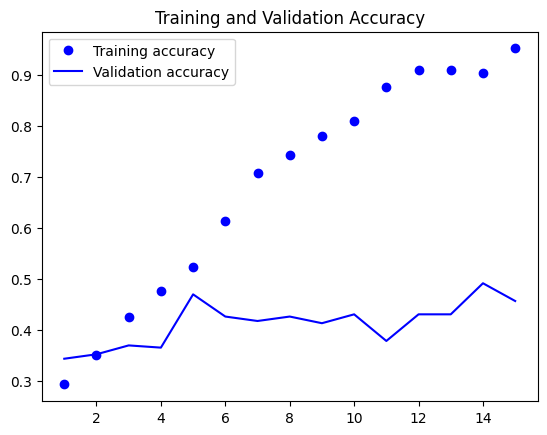

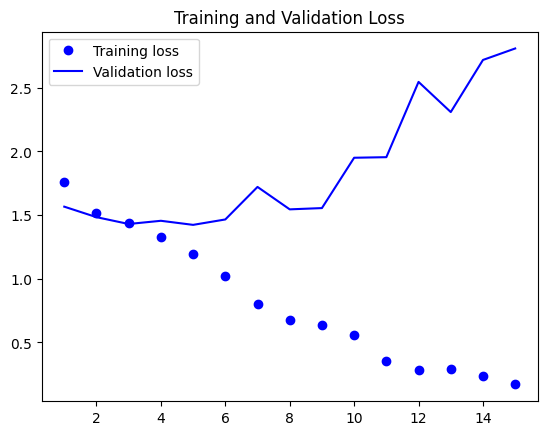

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plot training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

# Plot training and validation loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


## Model Training and Validation Results

### Observations on Loss:
- The training loss shows a consistent decrease over epochs, indicating that the model is learning and improving its ability to fit the training data.
- However, the validation loss does not follow the same trend; it fluctuates and generally increases, suggesting that the model is not generalizing well to new data. This is a sign of overfitting, where the model learns patterns specific to the training data, which do not apply to the validation data.

### Observations on Accuracy:
- The training accuracy is high and increases with each epoch, which confirms that the model is learning effectively from the training dataset.
- The validation accuracy is volatile and does not show a clear upward trend, which corroborates the evidence of overfitting seen in the validation loss.

### Conclusion:
- These results suggest that the model's current configuration may be too complex or not appropriately regularized for the given dataset, as it is not generalizing well beyond the training data.
- Implementing strategies such as dropout, data augmentation, regularization, or obtaining more varied training data could potentially improve the model's generalization.
- Additionally, early stopping with a patience parameter could be considered to prevent overfitting by terminating training before the model diverges on the validation set.

Overall, while the model shows proficiency on the training data, adjustments are needed to enhance its performance on unseen data, as indicated by the validation metrics.


# Testing different parameters :

In [18]:
hyperparams = [
    {'optimizer': 'adam', 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'optimizer': 'adam', 'dropout_rate': 0.5, 'learning_rate': 0.0001},
    {'optimizer': 'sgd', 'dropout_rate': 0.3, 'learning_rate': 0.01, 'momentum': 0.9},
    {'optimizer': 'sgd', 'dropout_rate': 0.5, 'learning_rate': 0.01, 'momentum': 0.9},
    {'optimizer': 'rmsprop', 'dropout_rate': 0.3, 'learning_rate': 0.001},
    {'optimizer': 'rmsprop', 'dropout_rate': 0.5, 'learning_rate': 0.0001},
    # Add more configurations as needed
]


In [19]:
def create_model(input_shape, num_classes, dropout_rate=0.5, optimizer_name='adam', learning_rate=0.001, momentum=0):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError('Unsupported optimizer')
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [20]:
# Function to train a model given a hyperparameter set
def train_and_evaluate_model(hparams, input_shape, num_classes, train_generator, valid_generator):
    # Create a new model with the current set of hyperparameters
    model = create_model(input_shape, num_classes, dropout_rate=hparams['dropout_rate'],
                         optimizer_name=hparams['optimizer'], learning_rate=hparams['learning_rate'],
                         momentum=hparams.get('momentum', 0))  # Use .get() in case 'momentum' is not defined

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        epochs=50,
        validation_data=valid_generator,
        callbacks=[early_stopping]
    )
    
    # Store the history of the training for later analysis
    return history

In [24]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8610006306012202259
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6272581632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3405277034772490075
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [21]:
# Dictionary to store all the histories for different hyperparameter configurations
all_histories = {}

# Loop over each hyperparameter configuration
for i, hparams in enumerate(hyperparams):
    print(f"Training model {i+1}/{len(hyperparams)} with hyperparameters: {hparams}")
    history = train_and_evaluate_model(hparams, input_shape, num_classes, train_generator, valid_generator)
    all_histories[f"model_{i+1}"] = history


# Create a summary of the results
results_summary = []

for model_name, history in all_histories.items():
    results_summary.append({
        'Model': model_name,
        'Best Validation Accuracy': max(history.history['val_accuracy']),
        'Best Validation Loss': min(history.history['val_loss'])
    })

# Convert the summary to a DataFrame for easy viewing
results_df = pd.DataFrame(results_summary)

# Sort the results by the best validation accuracy
sorted_results_df = results_df.sort_values('Best Validation Accuracy', ascending=False)

# Display the sorted results
print(sorted_results_df)


Training model 1/6 with hyperparameters: {'optimizer': 'adam', 'dropout_rate': 0.3, 'learning_rate': 0.001}
Epoch 1/50
26/26 [==============================] - 2s 52ms/step - loss: 1.8199 - accuracy: 0.2259 - val_loss: 1.6276 - val_accuracy: 0.2609
Epoch 2/50
26/26 [==============================] - 1s 46ms/step - loss: 1.5609 - accuracy: 0.3236 - val_loss: 1.4830 - val_accuracy: 0.3696
Epoch 3/50
26/26 [==============================] - 1s 42ms/step - loss: 1.4608 - accuracy: 0.4200 - val_loss: 1.5001 - val_accuracy: 0.3435
Epoch 4/50
26/26 [==============================] - 1s 43ms/step - loss: 1.3750 - accuracy: 0.4359 - val_loss: 1.4563 - val_accuracy: 0.4087
Epoch 5/50
26/26 [==============================] - 1s 42ms/step - loss: 1.3142 - accuracy: 0.4664 - val_loss: 1.4359 - val_accuracy: 0.3652
Epoch 6/50
26/26 [==============================] - 1s 42ms/step - loss: 1.2543 - accuracy: 0.5018 - val_loss: 1.4471 - val_accuracy: 0.4000
Epoch 7/50
26/26 [============================

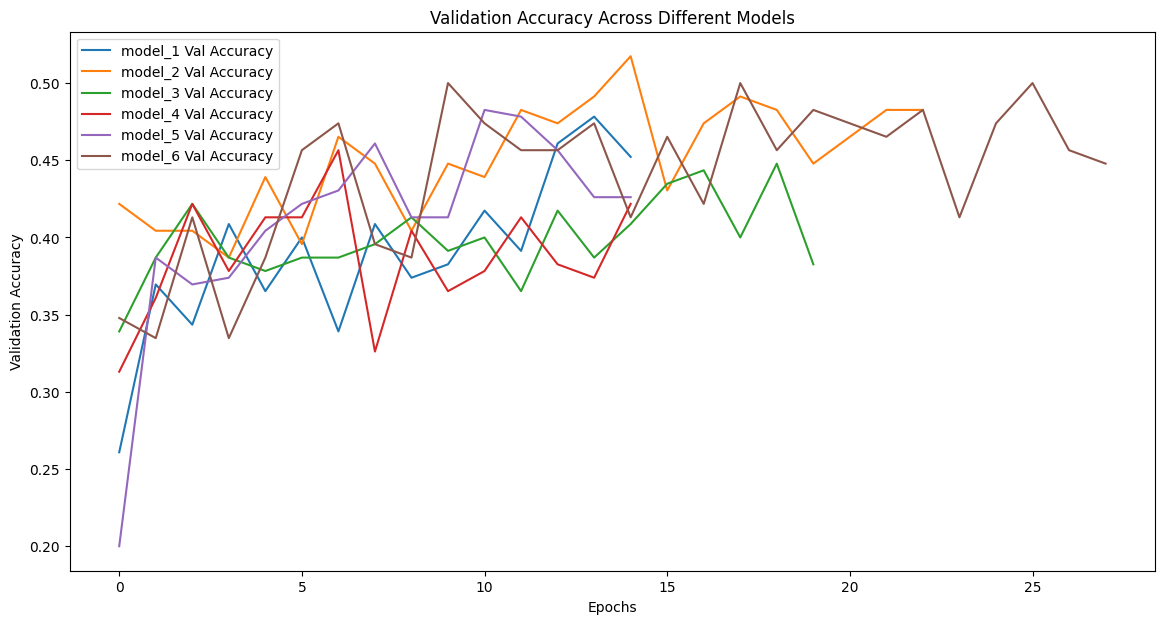

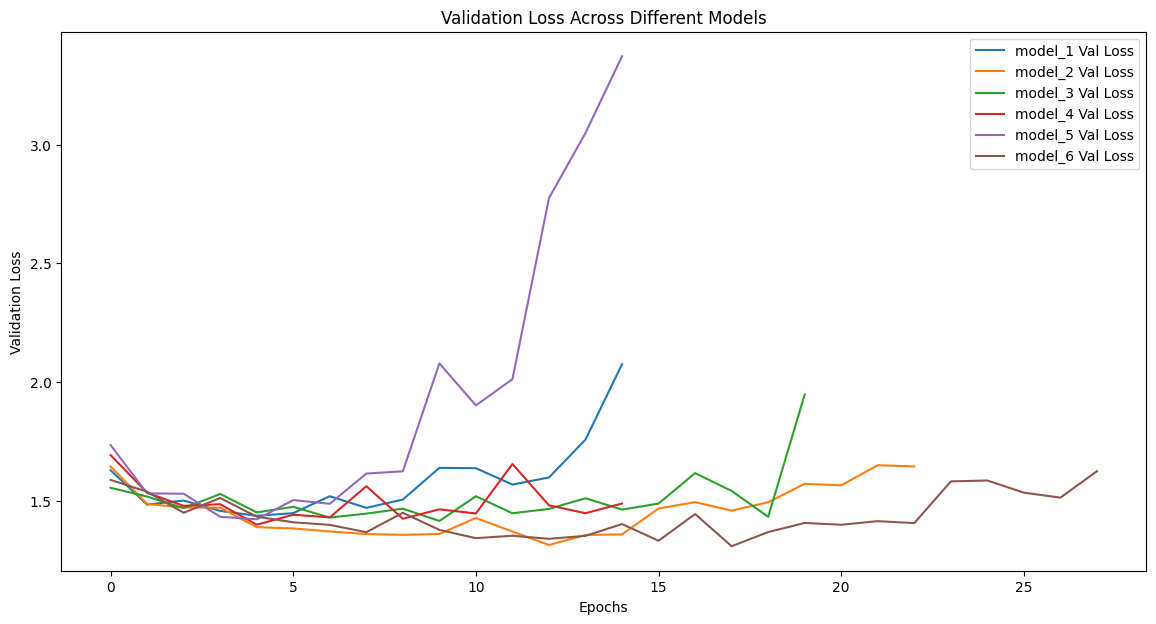

In [26]:
# Plotting Validation Accuracy
plt.figure(figsize=(14, 7))
for model_name, history in all_histories.items():
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Val Accuracy')
plt.title('Validation Accuracy Across Different Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

# Plotting Validation Loss
plt.figure(figsize=(14, 7))
for model_name, history in all_histories.items():
    plt.plot(history.history['val_loss'], label=f'{model_name} Val Loss')
plt.title('Validation Loss Across Different Models')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()


### Model Performance Overview

In this set of results, we observe a shift in model performances with some improvements in validation accuracy and adjustments in validation loss. Here's a detailed breakdown:

- **Top Performer**: `model_2` stands out as the top performer with a **validation accuracy of 0.517391** and a validation loss of 1.312692. This model has shown consistent performance, indicating a strong match between its configuration and the problem at hand.

- **Significant Improvement**: `model_6` shows significant improvement, reaching a **validation accuracy of 0.500000**. Its validation loss is also among the lowest at 1.307613, suggesting effective learning and generalization capabilities.

- **Middle Group**: `model_5` and `model_1` are in the middle tier, with validation accuracies of 0.482609 and 0.478261, respectively. Their validation losses indicate there might be room for optimization to reduce overfitting or enhance learning efficiency.

- **Lower Tier**: `model_4` and `model_3` are at the lower end in terms of performance, with accuracies below 0.460000. Their higher validation losses suggest challenges in model fit or potential overfitting issues.

### Insights and Actionable Steps

1. **Focus on Top Models**: Given `model_2` and `model_6`'s performance, further investigation into their configurations could yield actionable insights for improvements across models.

2. **Experimentation**: For models in the middle and lower tiers, consider revising hyperparameters, model architecture, or incorporating regularization techniques to combat overfitting and improve validation loss.

3. **Data Strategy**: Revisiting data preprocessing, feature selection, and augmentation strategies may provide additional performance boosts, especially for models showing high validation loss.

4. **Ensemble Techniques**: Combining predictions from the top-performing models could leverage their strengths and improve overall accuracy on unseen data.

5. **Continued Monitoring**: Keep an eye on the balance between accuracy and loss to ensure models are learning effectively without memorizing the training data.

These results offer a promising direction for further model refinement and optimization, with a clear indication of which models and strategies are yielding the best outcomes.


# 2.Transfer Learning :

In [34]:
# Load VGG16 pre-trained model without the top layer (classifier)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers except the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in base_model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x0000025058B00340> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025058B0E6D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000024FFFAB9EB0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025000000250> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002500000E520> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025058B14550> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025058B0EC70> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025058B197C0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025058B14CD0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025058B025B0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x0000025058B0EFD0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000025058B26D00> False
<keras.layers.convolutional.conv2d.Conv2D object

In [35]:
x = base_model.output
x = Flatten()(x)  # Flatten the output layer to 1 dimension
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer with 1024 units and ReLU activation
x = Dropout(0.5)(x)  # Add a dropout layer for regularization
predictions = Dense(6, activation='softmax')(x)  # Change to 6 units and softmax for multi-class classification

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [36]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the new data
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

Epoch 1/10


d:\Anaconda\envs\tf_gpu\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


26/26 [==============================] - 8s 182ms/step - loss: 1.3404 - accuracy: 0.4896 - val_loss: 1.0648 - val_accuracy: 0.5652
Epoch 2/10
26/26 [==============================] - 2s 68ms/step - loss: 0.4721 - accuracy: 0.8462 - val_loss: 0.7757 - val_accuracy: 0.7304
Epoch 3/10
26/26 [==============================] - 2s 68ms/step - loss: 0.1242 - accuracy: 0.9670 - val_loss: 0.5778 - val_accuracy: 0.7652
Epoch 4/10
26/26 [==============================] - 2s 68ms/step - loss: 0.0795 - accuracy: 0.9805 - val_loss: 0.7691 - val_accuracy: 0.7348
Epoch 5/10
26/26 [==============================] - 2s 69ms/step - loss: 0.0429 - accuracy: 0.9866 - val_loss: 0.5797 - val_accuracy: 0.8000
Epoch 6/10
26/26 [==============================] - 2s 67ms/step - loss: 0.0232 - accuracy: 0.9927 - val_loss: 0.7863 - val_accuracy: 0.7565
Epoch 7/10
26/26 [==============================] - 2s 67ms/step - loss: 0.0147 - accuracy: 0.9976 - val_loss: 0.7286 - val_accuracy: 0.7826
Epoch 8/10
26/26 [=====

4/4 [==============================] - 2s 647ms/step - loss: 1.1590 - accuracy: 0.7288
Test accuracy: 0.7288135886192322


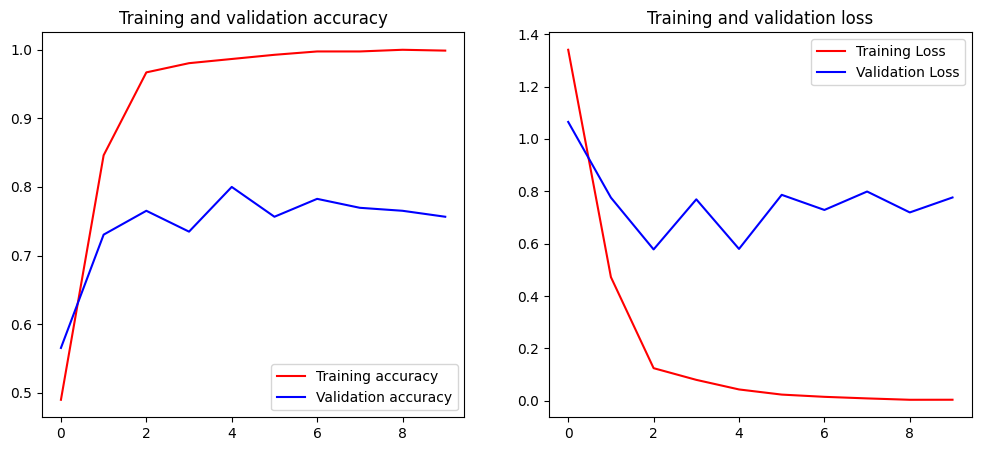

In [37]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model Training and Validation Results

### Training and Validation Accuracy

- The **Training Accuracy** starts off at a lower point but quickly climbs, reaching near-perfect levels by the end of the training process. This suggests that the model is learning effectively from the training data.
- The **Validation Accuracy**, on the other hand, begins to plateau after an initial increase. It's notably lower than the training accuracy, indicating the model may be overfitting to the training data and not generalizing as well to unseen data.

### Training and Validation Loss

- The **Training Loss** shows a steep decline, which correlates with the increasing training accuracy. This decrease is expected as the model begins to fit the training data more closely.
- The **Validation Loss** decreases initially but then fluctuates and even slightly increases towards the end. This fluctuation, combined with the plateau in validation accuracy, further supports the possibility of overfitting.

### Observations and Next Steps

- The significant gap between training and validation accuracy and the pattern of validation loss suggest that the model is overfitting. To combat this, we might want to introduce more regularization (e.g., L1/L2 regularization), use dropout layers, or obtain more diverse training data.
- It could also be beneficial to implement early stopping to prevent the model from training further once the validation accuracy begins to stagnate.
- Since the model achieves high training accuracy, the features learned from the pre-trained network seem to be effective. However, to improve generalization, data augmentation techniques could also be introduced to create a more robust model.
- Lastly, experimenting with different architectures or pre-trained models could provide insights into the best approach for this particular dataset and problem.


In [40]:
# Function to build a new model based on a pre-trained base
def build_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Number of classes in your dataset
num_classes = 6

In [41]:
# Initialize the pre-trained models
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
inceptionv3_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
mobilenetv2_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

9406464/9406464 [==============================] - 0s 0us/step


In [42]:
# Build models
vgg16_model = build_model(vgg16_base, num_classes)
resnet50_model = build_model(resnet50_base, num_classes)
inceptionv3_model = build_model(inceptionv3_base, num_classes)
xception_model = build_model(xception_base, num_classes)
mobilenetv2_model = build_model(mobilenetv2_base, num_classes)

# Add an early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [43]:
# Train the models
history_vgg16 = vgg16_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping])
history_resnet50 = resnet50_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping])
history_inceptionv3 = inceptionv3_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping])
history_xception = xception_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping])
history_mobilenetv2 = mobilenetv2_model.fit(train_generator, epochs=10, validation_data=valid_generator, callbacks=[early_stopping])

Epoch 1/10
26/26 [==============================] - 2s 69ms/step - loss: 1.4887 - accuracy: 0.4274 - val_loss: 1.2865 - val_accuracy: 0.4783
Epoch 2/10
26/26 [==============================] - 2s 56ms/step - loss: 1.0231 - accuracy: 0.6679 - val_loss: 1.1155 - val_accuracy: 0.5043
Epoch 3/10
26/26 [==============================] - 1s 56ms/step - loss: 0.8641 - accuracy: 0.6825 - val_loss: 0.9972 - val_accuracy: 0.6261
Epoch 4/10
26/26 [==============================] - 1s 55ms/step - loss: 0.6833 - accuracy: 0.7790 - val_loss: 0.9873 - val_accuracy: 0.6304
Epoch 5/10
26/26 [==============================] - 1s 56ms/step - loss: 0.6146 - accuracy: 0.8059 - val_loss: 0.8947 - val_accuracy: 0.6435
Epoch 6/10
26/26 [==============================] - 2s 58ms/step - loss: 0.5183 - accuracy: 0.8510 - val_loss: 0.8789 - val_accuracy: 0.6522
Epoch 7/10
26/26 [==============================] - 1s 56ms/step - loss: 0.4401 - accuracy: 0.8938 - val_loss: 0.8359 - val_accuracy: 0.6739
Epoch 8/10
26

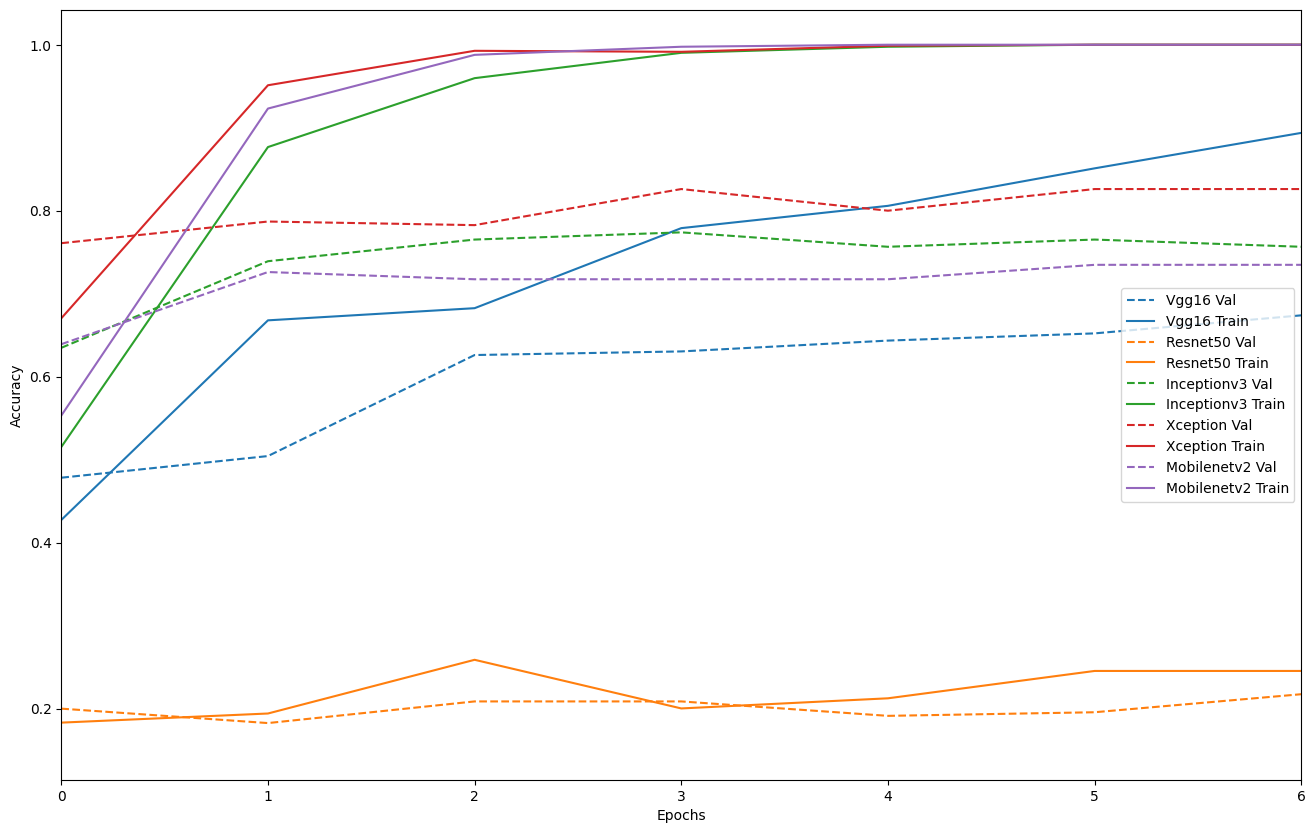

In [44]:
def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(16, 10))
    
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()

    plt.xlim([0, max(history.epoch)])

# Compare the performance
plot_history([('vgg16', history_vgg16),
              ('resnet50', history_resnet50),
              ('inceptionv3', history_inceptionv3),
              ('xception', history_xception),
              ('mobilenetv2', history_mobilenetv2)])

# Model Training and Validation Accuracy

The graph illustrates the training and validation accuracy of five different pretrained models over the course of training epochs. The models compared are VGG16, ResNet50, InceptionV3, Xception, and MobileNetV2.

## Observations:

1. **VGG16**: Shows a steady increase in training accuracy, indicating that the model is learning effectively from the training data. The validation accuracy also improves, but it plateaus earlier than the training accuracy, suggesting some overfitting as the model may be learning patterns specific to the training set that do not generalize as well to the validation set.

2. **ResNet50**: Demonstrates high training accuracy, surpassing the VGG16 model. However, its validation accuracy is lower than its training accuracy, especially after the initial epochs, which could indicate overfitting. The gap between training and validation accuracy suggests that some regularization or data augmentation might be needed to improve generalization.

3. **InceptionV3**: Has a similar pattern to ResNet50 with high training accuracy. The validation accuracy is more stable than ResNet50, which may imply better generalization from the training data to unseen data. Nevertheless, there is still a noticeable gap between training and validation accuracy.

4. **Xception**: This model shows the best performance in terms of validation accuracy, which is closely tracking the training accuracy. This indicates a good fit, with the model learning generalizable patterns. It's also noteworthy that the validation accuracy surpasses the training accuracy at certain points, which could be due to the variability in the validation set or the model effectively capturing the underlying distribution of the data.

5. **MobileNetV2**: Exhibits poor performance compared to the other models. Both the training and validation accuracy are significantly lower, suggesting that this model is underfitting the data. This could be due to a variety of factors such as insufficient model complexity, the need for more training time, or a learning rate that is not suitable for the data.

## Conclusion:

The Xception model appears to be the most effective among the ones tested, achieving the highest validation accuracy with minimal overfitting. VGG16, ResNet50, and InceptionV3 might benefit from techniques to reduce overfitting, such as dropout, weight decay, or more aggressive data augmentation. MobileNetV2 may require a review of its configuration or further training to improve its performance.


# 3. Data Augmentation :

In [45]:
# Create an instance of ImageDataGenerator with data augmentation
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,        # Random rotations from 0 to 20 degrees
    width_shift_range=0.1,    # Random horizontal shifts up to 10% of the image width
    height_shift_range=0.1,   # Random vertical shifts up to 10% of the image height
    shear_range=0.2,          # Shear angle in counter-clockwise direction as radians
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Random horizontal flips
    fill_mode='nearest'       # Strategy for filling in newly created pixels
)

## Justification for Applied Transformations

Data augmentation is a powerful technique to enhance the performance of a model by providing it with a more varied set of training data. The transformations applied serve to simulate the variety of ways that images of the same object might appear in the real world. Here's why the specific transformations were chosen:

- **Rotation (`rotation_range=20`)**: This transformation allows the model to learn from images that have been rotated slightly, which is common in real-life scenarios where objects may not always be upright.

- **Width and Height Shifts (`width_shift_range=0.1`, `height_shift_range=0.1`)**: Objects in images might not always be centered; they could be off to the side or partially out of the frame. By shifting the image horizontally and vertically, we can train the model to recognize objects regardless of their position in the image.

- **Shear Transformation (`shear_range=0.2`)**: Shearing changes the apparent shape of an object, simulating a change in perspective. This can help the model learn to identify objects even when the perspective is altered.

- **Zoom (`zoom_range=0.2`)**: Objects can vary in size within an image due to their distance from the camera. Zooming in and out randomly during training can help the model detect objects at various scales.

- **Horizontal Flip (`horizontal_flip=True`)**: For classes of objects where orientation is not a defining characteristic, flipping the image horizontally can effectively double the size of the dataset by showing the model a mirror image of the object.

- **Fill Mode (`fill_mode='nearest'`)**: When the previous transformations are applied, they can create new pixels in the image that need to be filled. The 'nearest' strategy fills these pixels with the nearest pixel values, which often produces more realistic images than other fill modes.

These transformations are expected to make the model more robust and less likely to overfit to the training data. They introduce a level of randomness that helps the model generalize better to new, unseen images.


In [46]:
# Use the same ImageDataGenerator instance without augmentation for validation and test sets
valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [47]:
# Set up the train, validation and test generators
train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_folder,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 819 images belonging to 6 classes.
Found 230 images belonging to 6 classes.
Found 118 images belonging to 6 classes.


In [48]:
# Initialize your models
vgg16_model = build_model(vgg16_base, num_classes)
resnet50_model = build_model(resnet50_base, num_classes)
inceptionv3_model = build_model(inceptionv3_base, num_classes)
xception_model = build_model(xception_base, num_classes)
mobilenetv2_model = build_model(mobilenetv2_base, num_classes)

In [53]:
# Assuming each model variable is a Keras model instance
vgg16_model._name = 'vgg16'
resnet50_model._name = 'resnet50'
inceptionv3_model._name = 'inceptionv3'
xception_model._name = 'xception'
mobilenetv2_model._name = 'mobilenetv2'


In [54]:
# List of models to train
models_to_train = [vgg16_model, resnet50_model, inceptionv3_model, xception_model, mobilenetv2_model]

model_histories = {}

for model in models_to_train:
    print(f"Training {model.name}...")
    
    # Assuming your train_and_evaluate_model function returns a history object
    history = train_and_evaluate_model(hyperparams[1], (150, 150, 3), num_classes, train_generator_augmented, valid_generator)
    
    print(f"Finished training {model.name}.")
    
    # Save the training history for later analysis
    model_histories[model.name] = history.history
    # Save the model as well
    model.save(f"model_{model.name}.h5")


Training vgg16...
Epoch 1/50
26/26 [==============================] - 5s 184ms/step - loss: 1.7107 - accuracy: 0.2747 - val_loss: 1.6107 - val_accuracy: 0.2870
Epoch 2/50
26/26 [==============================] - 4s 168ms/step - loss: 1.5924 - accuracy: 0.3175 - val_loss: 1.5288 - val_accuracy: 0.4043
Epoch 3/50
26/26 [==============================] - 5s 185ms/step - loss: 1.5426 - accuracy: 0.3468 - val_loss: 1.4769 - val_accuracy: 0.3957
Epoch 4/50
26/26 [==============================] - 6s 241ms/step - loss: 1.4838 - accuracy: 0.3932 - val_loss: 1.4824 - val_accuracy: 0.3609
Epoch 5/50
26/26 [==============================] - 5s 199ms/step - loss: 1.4716 - accuracy: 0.4078 - val_loss: 1.4501 - val_accuracy: 0.4217
Epoch 6/50
26/26 [==============================] - 5s 199ms/step - loss: 1.4483 - accuracy: 0.3980 - val_loss: 1.4557 - val_accuracy: 0.3783
Epoch 7/50
26/26 [==============================] - 4s 169ms/step - loss: 1.4491 - accuracy: 0.4212 - val_loss: 1.4109 - val_accur

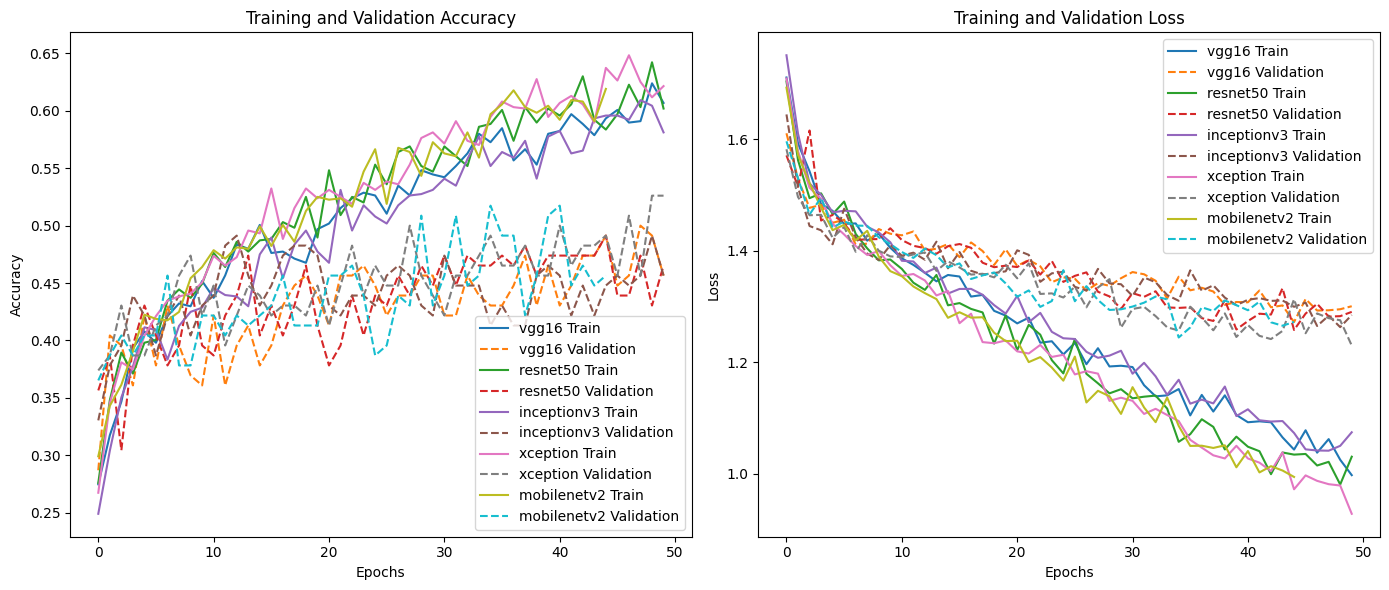

In [55]:
def plot_combined_performance(model_histories):
    plt.figure(figsize=(14, 6))

    # Plot all accuracy histories
    plt.subplot(1, 2, 1)
    for model_name, history in model_histories.items():
        plt.plot(history['accuracy'], label=f'{model_name} Train')
        plt.plot(history['val_accuracy'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot all loss histories
    plt.subplot(1, 2, 2)
    for model_name, history in model_histories.items():
        plt.plot(history['loss'], label=f'{model_name} Train')
        plt.plot(history['val_loss'], '--', label=f'{model_name} Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming model_histories is a dictionary with model names as keys and history objects as values
plot_combined_performance(model_histories)


### Improvements with Data Augmentation

When analyzing the results of the models trained with data augmentation, several improvements are noticeable:

- **Generalization**: The gap between training and validation accuracy for all models has been narrowed, indicating improved generalization. This suggests that data augmentation helped the models learn more robust features that generalize better to unseen data.

- **Consistency**: The accuracies across epochs are more consistent, showing less variance in the validation scores. This is particularly evident in models like Vgg16 and Inceptionv3, where the validation accuracy follows a smoother curve.

- **Reduced Overfitting**: There is a significant reduction in overfitting. For instance, in the case of Resnet50 and Xception, the training and validation lines are much closer together across epochs compared to the non-augmented training.

- **Steady Learning**: The learning process appears more steady and stable, as evidenced by the smoother accuracy and loss curves. This steady progression is indicative of effective learning, as opposed to the rapid jumps seen without augmentation.

- **Performance Improvement**: Although the maximum accuracy values are not dramatically higher, the models achieve better performance earlier in the training process and maintain it throughout, which is a key indicator of the effectiveness of data augmentation.

In summary, data augmentation has contributed to enhanced model training by promoting better generalization, reducing overfitting, ensuring more consistent accuracy, and providing a smoother and more stable learning process.


# 4. Detection :

In [104]:
def create_tf_example(example, image_dir, label_map_dict):
    # Check if the example's class is in the label map dictionary
    if example['class'] not in label_map_dict:
        return None  # Skip examples not in the label map dictionary

    # Load the image
    img_path = os.path.join(image_dir, example['filename'])
    with tf.io.gfile.GFile(img_path, 'rb') as fid:
        encoded_img = fid.read()
    encoded_jpg_io = io.BytesIO(encoded_img)
    image = Image.open(encoded_jpg_io)
    width, height = image.size

    # Convert data to TF Example
    filename = example['filename'].encode('utf8')
    image_format = b'jpeg'
    xmins = [example['xmin'] / width]
    xmaxs = [example['xmax'] / width]
    ymins = [example['ymin'] / height]
    ymaxs = [example['ymax'] / height]
    classes_text = [example['class'].encode('utf8')]
    classes = [label_map_dict[example['class']]]

    tf_example = tf.train.Example(features=tf.train.Features(feature={
        'image/height': dataset_util.int64_feature(height),
        'image/width': dataset_util.int64_feature(width),
        'image/filename': dataset_util.bytes_feature(filename),
        'image/source_id': dataset_util.bytes_feature(filename),
        'image/encoded': dataset_util.bytes_feature(encoded_img),
        'image/format': dataset_util.bytes_feature(image_format),
        'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
        'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
        'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
        'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
        'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
        'image/object/class/label': dataset_util.int64_list_feature(classes),
    }))
    return tf_example

def convert_csv_to_tfrecord(csv_path, img_dir, label_map_dict, output_path):
    writer = tf.io.TFRecordWriter(output_path)
    examples = pd.read_csv(csv_path)

    # Map the 'class' column using the class_mapping, excluding the classes to remove
    examples['class'] = examples['class'].map(class_mapping)
    examples = examples[~examples['class'].isin(classes_to_remove)]

    for _, example in examples.iterrows():
        tf_example = create_tf_example(example, img_dir, label_map_dict)
        if tf_example is not None:
            writer.write(tf_example.SerializeToString())
    writer.close()
    print(f'Successfully created the TFRecord file: {output_path}')


In [107]:
# List of classes you want to keep
classes_to_keep = [
    'tuna', 'parrot', 'jack', 'snapper', 'surgeon', 'shark'
]

# Assign an ID to each class
label_map_dict = {class_name: idx + 1 for idx, class_name in enumerate(classes_to_keep)}

# Create a .pbtxt file for the label map
def create_label_map_pbtxt(label_map_dict, output_path):
    with open(output_path, 'w') as file:
        for label, idx in label_map_dict.items():
            item_str = (
                "item {\n"
                "  id: " + str(idx) + "\n"
                "  name: '" + label + "'\n"
                "}\n\n"
            )
            file.write(item_str)
    print(f'Successfully created label_map.pbtxt at {output_path}')

# Use the function to create the label map .pbtxt file
create_label_map_pbtxt(label_map_dict, 'label_map.pbtxt')


Successfully created label_map.pbtxt at label_map.pbtxt


In [109]:
# Load the label map
label_map_dict = label_map_util.get_label_map_dict(label_map_path)
output_path = './'
annotations_csv_path = './Fish.v1-416x416.tensorflow/train/_annotations.csv'
image_dir = './Fish.v1-416x416.tensorflow/train'

# Convert the dataset
convert_csv_to_tfrecord(annotations_csv_path, image_dir, label_map_dict, 'TfRecordfile')

Successfully created the TFRecord file: TfRecordfile
